In [1]:
import nltk
from nltk.corpus import brown
nltk.download('brown')
nltk.download('universal_tagset')
corpus = brown.tagged_sents(tagset='universal')
corpus

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\DIMITRIS\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\DIMITRIS\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [2]:
len(corpus)

57340

In [3]:
inputs = []
targets = []
for sentence_tag_pairs in corpus:
    tokens = []
    target = []
    for token,tag in sentence_tag_pairs:
        tokens.append(token)
        target.append(tag)
    inputs.append(tokens)
    targets.append(target)

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM,GRU,Embedding, Bidirectional, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [5]:
train_inputs,test_inputs, train_targets,test_targets = train_test_split(
    inputs,
    targets,
    test_size=0.3,
)
MAX_VOCAB_SIZE = None
should_lowercase = False
tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=should_lowercase,
    oov_token = 'UKN',
)
# oov_token 
# otherwise len(input) != len(targets) -> not aligned!!

tokenizer.fit_on_texts(train_inputs)
train_inputs_int = tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = tokenizer.texts_to_sequences(test_inputs)


In [6]:
# word -> idx mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print(f"unique tokens {V}")


unique tokens 47575


In [7]:
def flatten(list_of_lists):
    return [val for sublist in list_of_lists for val in sublist]

all_train_targets = set(flatten(train_targets))    
all_test_targets = set(flatten(test_targets))    

In [8]:
all_train_targets == all_test_targets

True

In [13]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

# save for later
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

# find max document lenght
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)

T = max((maxlen_test,maxlen_train))

# pad sequences
train_inputs_int = pad_sequences(train_inputs_int,maxlen=T)
test_inputs_int = pad_sequences(test_inputs_int,maxlen=T)
train_targets_int =pad_sequences(train_targets_int,maxlen=T)
test_targets_int=pad_sequences(test_targets_int,maxlen=T)
print(train_inputs_int.shape)
print(test_inputs_int.shape)

(40138, 180)
(17202, 180)


In [14]:
K = len(tag_tokenizer.word_index)+1
K

13

In [15]:
# embedding dimenstionality
D = 32
i = Input(shape=(T,))
#mask_zero = True way slower on gpu
# necessary to ignore padding
x = Embedding(V+1,D,mask_zero=True)(i)
# bidectional creates 2 lstm, oone for forward pass one backward pass
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i,x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 180, 32)   │  1,522,432 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 180)       │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 180, 64)   │     16,640 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 180, 13)   │        845 │ bidirectional_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,539,917 (5.87 MB)

 Trainable params: 1,539,917 (5.87 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# compile and fit 

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'],
)

r = model.fit(
    train_inputs_int,
    train_targets_int,
    epochs=5,
    validation_data=(test_inputs_int,test_targets_int)
)

Epoch 1/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 163s 126ms/step - accuracy: 0.0848 - loss: 0.9450 - val_accuracy: 0.1095 - val_loss: 0.1085
Epoch 2/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 146s 117ms/step - accuracy: 0.1091 - loss: 0.0752 - val_accuracy: 0.1102 - val_loss: 0.0867
Epoch 3/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 145s 116ms/step - accuracy: 0.1102 - loss: 0.0453 - val_accuracy: 0.1104 - val_loss: 0.0838
Epoch 4/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 145s 115ms/step - accuracy: 0.1099 - loss: 0.0331 - val_accuracy: 0.1104 - val_loss: 0.0857
Epoch 5/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 144s 115ms/step - accuracy: 0.1115 - loss: 0.0251 - val_accuracy: 0.1104 - val_loss: 0.0912


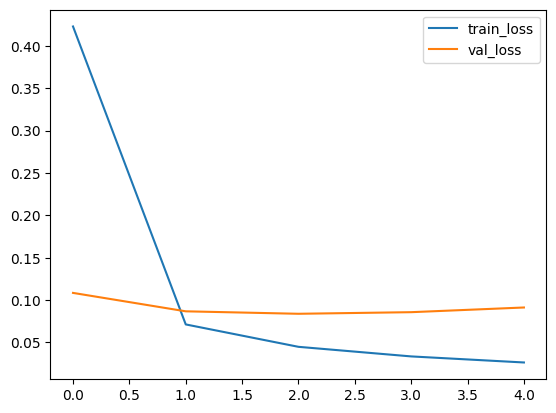

In [17]:
plt.plot(r.history['loss'],label='train_loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

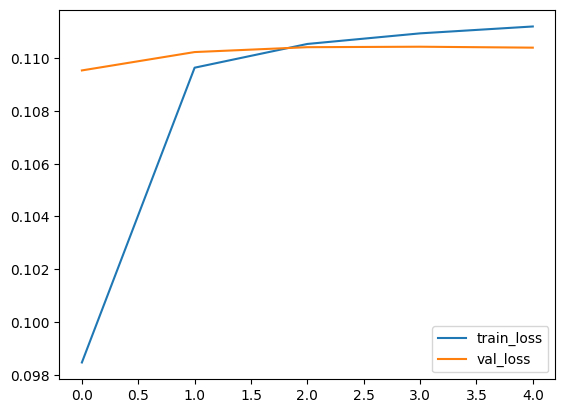

In [18]:
plt.plot(r.history['accuracy'],label='train_loss')
plt.plot(r.history['val_accuracy'],label='val_loss')
plt.legend()